Circular buffer

In [122]:
import collections
buf = collections.deque(maxlen=5)
buf

deque([])

we have a buffer consisting of 6 images

In [154]:
arr = [i+1 for i in range(6) ]
arr

[1, 2, 3, 4, 5, 6]

we update the buffer with the 7th image (our counter is at 6)

In [155]:
ctr = 6
arr[ctr % len(arr)] = 7
arr

[7, 2, 3, 4, 5, 6]

i want to get the last 4 items

In [160]:
print arr[ctr % len(arr)], arr[ (ctr-1) % len(arr) ], arr[ (ctr-2) % len(arr) ], arr[ (ctr-3) % len(arr) ]

7 6 5 4


In [165]:
#we get another image and add it
ctr += 1
arr[ctr % len(arr)] = 8
arr

[7, 8, 3, 4, 5, 6]

In [167]:
# get the last 4 items
print arr[ctr % len(arr)], arr[ (ctr-1) % len(arr) ], arr[ (ctr-2) % len(arr) ], arr[ (ctr-3) % len(arr) ]

8 7 6 5


In [170]:
ctr % len(arr)

1

question: what if ctr overflows?? should we just set it to 0 provided when ctr % len(arr) == 0 as well??

----------

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import gym
env = gym.make('Pong-v0')
print(env.action_space)
print(env.observation_space)

[2017-03-08 12:11:50,276] You have 'numpy' version 1.10.1 installed, but 'gym' requires at least 1.10.4. HINT: upgrade via 'pip install -U numpy'.
[2017-03-08 12:11:50,312] Making new env: Pong-v0


Discrete(6)
Box(210, 160, 3)


In [13]:
env.observation_space.shape

(210, 160, 3)

In [3]:
obs, reward, done, info = env.step(0)

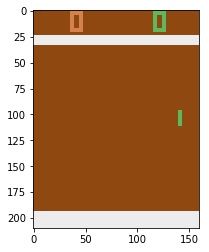

In [7]:
plt.imshow(obs)

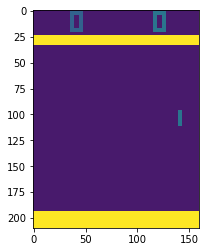

In [41]:
img = np.transpose(obs, (2, 0, 1))
plt.imshow(img[2])

In [52]:
np.mean(img, axis=0, keepdims=True).shape, img.shape

((1, 210, 160), (3, 210, 160))

In [67]:
img_batch = np.asarray([img,img,img,img,img])
img_batch = img_batch.astype("float32")
img_batch.shape

(5, 3, 210, 160)

In [61]:
import os
os.environ["HDF5_DISABLE_VERSION_CHECK"] = "1"
from keras.preprocessing.image import ImageDataGenerator

In [117]:
imgen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

In [118]:
for x, _ in imgen.flow(np.asarray([img]), np.asarray([0])):
    print x.shape
    break

(1, 3, 210, 160)


Samplewise centering with Keras data augmentor: for an image of dim (b, f, h, w), the mean is (b, 1, h, w), i.e. we stdize over the feature map axis. For feature-wise, we also do the mean over bs axis.

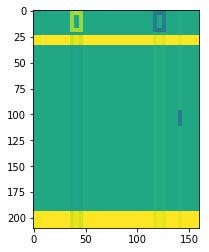

In [119]:
plt.imshow( imgen.standardize(img.astype("float32")[0]) )

The technique I have always used in the past (which I'm not sure is standard practice): the mean is (f,1), so each feature map gets a mean over all the pixels

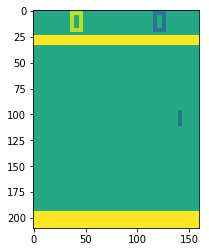

In [121]:
plt.imshow( (img[0] - np.mean(img[0])) / np.std(img[0]) )

----------

In [172]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.objectives import *
from lasagne.nonlinearities import *

In [28]:
def q_net(env):
    height, width, nchannels = env.observation_space.shape
    l_in = InputLayer((None, nchannels, height, width))
    l_conv = Conv2DLayer(l_in, num_filters=32, filter_size=3, stride=2)
    l_conv2 = Conv2DLayer(l_conv, num_filters=64, filter_size=3, stride=2)
    l_conv3 = Conv2DLayer(l_conv2, num_filters=96, filter_size=3, stride=2)
    l_conv4 = Conv2DLayer(l_conv3, num_filters=128, filter_size=3, stride=2)
    l_dense = DenseLayer(l_conv4, num_units=env.action_space.n)
    return l_dense

In [245]:
X = T.tensor4('X')
y = T.fmatrix('y') # one hot matrix
action_mask = T.fmatrix('action_mask')

In [223]:
l_out = q_net(env)
print count_params(l_out)
for layer in get_all_layers(l_out):
    print layer, layer.output_shape

268454
<lasagne.layers.input.InputLayer object at 0x11d5b9690> (None, 3, 210, 160)
<lasagne.layers.conv.Conv2DLayer object at 0x11d5b9810> (None, 32, 104, 79)
<lasagne.layers.conv.Conv2DLayer object at 0x11d5b9950> (None, 64, 51, 39)
<lasagne.layers.conv.Conv2DLayer object at 0x11d5b9b50> (None, 96, 25, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x11d5b9e50> (None, 128, 12, 9)
<lasagne.layers.dense.DenseLayer object at 0x11d749190> (None, 6)


In [246]:
q_out = get_output(l_out, X)
q_out

Elemwise{mul,no_inplace}.0

Let's do an example y matrix.

In [262]:
ytest = np.asarray([[1],[2],[1],[3.5],[4],[1.]])
ytest

array([[ 1. ],
       [ 2. ],
       [ 1. ],
       [ 3.5],
       [ 4. ],
       [ 1. ]])

We now need a mask for the Q. Suppose that for the random minibatch, for the first element we selected the first action, then for the second element we selected the second action, etc....

In [263]:
masktest = np.eye(6)
masktest

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [265]:
loss = y - (action_mask*q_out).sum(axis=1)
loss

Elemwise{sub,no_inplace}.0

-------------

In [224]:
q_out = get_output(l_out, X)
q_out_actions = q_out[T.arange(0, q_out.shape[0]), action_idxs]
q_out_actions

AdvancedSubtensor.0

In [226]:
#q_out_actions.eval({X:img_batch, action_idxs: np.asarray([[1],[2],[3],[3],[1]]).astype("int32")}).shape
q_out_actions.eval({X:img_batch, action_idxs: np.asarray([1,2,3,3,1]).astype("int32")}).shape

(5,)

Let's try out this fancy indexing

In [227]:
l_in = InputLayer((None, 2))

In [239]:
X = T.fmatrix('X')
input_ = get_output(l_in, X)
sliced_input = input_[ T.arange(input_.shape[0]), action_idxs]

In [240]:
input_.eval({
    X: np.asarray([[1,2],[3,4]]).astype("float32")
})

array([[ 1.,  2.],
       [ 3.,  4.]], dtype=float32)

In [241]:
sliced_input.eval({
    X: np.asarray([[1,2],[3,4]]).astype("float32"),
    action_idxs: np.asarray([0,1]).astype("int32")
})

array([ 1.,  4.], dtype=float32)

----

In [244]:
np.ones((10,20)).sum(axis=1).shape

(10,)